# Assingment 3.1 Data Preprocessing
### Leonard Littleton and Andrew Zazueta

## Libraries

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date

## Reading In Data

In [67]:
df = pd.read_csv("SD_ParticipantMonthlySnapshot_Joined.csv")
df.head()

,Participant Key,Clinic Key,Household Key,WIC Priority Key,WIC Category Key,Proof Of Residency,Proof Of ID,Appointment Reminder Type,TV/Video Viewing,Hemoglobin,Hematocrit,Lead Level,EP,Height,Weight,BMI,Application Count,Waiting List Count,Ineligible Count,Enrolled Count,Participating Count,Participating Not Enrolled Count,Terminated Count,Disqualified Count,Certification Start Date,Certification End Date,Benefit Start Date,Bloodwork Measurement Date,Anthropometric Measurement Date,Household Income Assessed Date,Food Package,Food Package Description,Food Package III Flag,Food Package Type,Food Prescription Date,Reporting Month Date,Clinic Name,Clinic FIPS Code,Clinic Status,Clinic Address,Clinic City,Clinic Zip Code,Clinic County,Local Agency Id,Local Agency Name,Local Agency Address,Local Agency City,Local Agency Zip Code,Local Agency County Code,Local Agency County,Local Agency Active Status,Household Id,Household Size,Household Income,Household Income Assessed Date.1,Household Income Qualified,Household Active Status,Household City,Household Zip Code,Household County,Household Time Zone,Household Daylight Savings Flag,Household County FIPS Id,Household Do Not Call Flag,Household Do Not Text Flag,Household Do Not Email Flag,Participant Id,Participant Date Of Birth,Participant Gender,Participant Ethnicity Flag,Participant Home Contact Flag,Participant Race,Participant HouseholdId,Medicaid Flag,SNAP Flag,TANF Flag,Child Health Insurance Program Flag,Private Insurance Flag,Physically Present Flag,Primary Language,Intrepreter Needed,Poverty Level,Voter Registration Requested,Mothers Education Level,Migrant Flag,Homeless,Smoking In The Household,Foster Care Flag,Mother ID,Mother Date Of Birth,Expected Delivery Date,Participant Status,Wic Category,Wic Subcategory,Wic Priority Id,Wic Priority,Wic Priority Desc
0,2360045,323338618,999000,420,399,Drivers License,Medicaid Card,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,1,2018-09-27,2019-01-07,2018-09-27,NaN,NaN,2018-03-19,NaN,NaN,NaN,NaN,NaN,2018-12-01,Freeman Clinic,46067,Active,804 S Walnut St,Freeman,57029,Hutchinson,5.0,Southeast Region,4101 W 38th Street,Sioux Falls,57106.0,46099.0,Minnehaha,Active,9243110,4,36400.0,2018-03-19 00:00:00.000,Yes,Inactive,Freeman,57029.0,Hutchinson,CST,Y,46067.0,Yes,No,Yes,300782194,2014-09-27,Male,No,No,White,9243110,No,No,No,No,No,Yes,English,No,78.0,No,College,No,No,No,,300775973,1984-09-20,NaN,Inactive,C4 Child Age 4,NaN,3,Priority 3,Priority 3
1,2360045,323338618,999000,420,399,Drivers License,Medicaid Card,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,1,1,1,1,2018-09-27,2019-01-07,2018-09-27,NaN,NaN,2018-03-19,NaN,NaN,NaN,NaN,NaN,2018-11-01,Freeman Clinic,46067,Active,804 S Walnut St,Freeman,57029,Hutchinson,5.0,Southeast Region,4101 W 38th Street,Sioux Falls,57106.0,46099.0,Minnehaha,Active,9243110,4,36400.0,2018-03-19 00:00:00.000,Yes,Inactive,Freeman,57029.0,Hutchinson,CST,Y,46067.0,Yes,No,Yes,300782194,2014-09-27,Male,No,No,White,9243110,No,No,No,No,No,Yes,English,No,78.0,No,College,No,No,No,,300775973,1984-09-20,NaN,Inactive,C4 Child Age 4,NaN,3,Priority 3,Priority 3
2,2362160,323338627,999123,420,396,South Dakota ID,Medicaid Card,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,1,1,2018-08-16,2018-11-30,NaN,NaN,NaN,2018-08-16,NaN,NaN,NaN,NaN,NaN,2018-11-01,Rapid City Clinic,46103,Active,909 E. St. Patrick St,Rapid City,57701,Pennington,1.0,West Region,1029 5th Street,Sturgis,57785.0,46093.0,Meade,Active,9245356,5,4200.0,2018-08-16 00:00:00.000,Yes,Inactive,Box Elder,57719.0,Pennington,MST,Y,46103.0,No,Yes,Yes,300784178,2014-12-01,Female,No,No,American Indian or Alaskan Native,9245356,Yes,Yes,No,No,No,Yes,English,No,8.0,No,Below High School,No,No,No,,300779334,1999-01-15,NaN,Inactive,C3 Child Age 3,NaN,3,Priority 3,Priority 3
3,2362160,323338627,999123,420,399,South Dakota ID,Medicaid Card,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,1,1,2018-12-01,2019-08-16,NaN,NaN,NaN,2018-08-16,NaN,NaN,NaN,NaN,NaN,2018-12-01,Rapid City Clinic,46103,Active

## Cleaning Data

#### Outline

Before we start to clean our data, we will list all the steps we want to take to ensure our data is ready for modeling:

##### Cleaning/EDA    
    Finding if there are duplicate rows
    Show data frame information for each feature
        - Finding percentage of rows that are NaN for each column
        - Seeing feature data types
    Removing columns where 30%+ are NaN
    Removing columns that do not aid model building
    Imputing mode into columns with NaN
    Removing rows where Participant Status = 'Pending'
    Making binary categorical feature values into zeros and ones
    Making categorical columns into boolean n-1 dummy features
    Creating a column which marks if the clinic city and household city are the same
    Removing outliers with the aid of box plots
    Finding correlation between columns with Correlation Matrix
        - Removing features with high correlation (0.7+)
    Normalizing non-binary numerical data to same units
##### EDA
    Seeing spread of target column to see if it is imbalanced
    Seeing spread of non-categorical numeric features with target colored

### Seeing data dimensions, data types, and null counts

In [68]:
# Original shape 

df.shape

(698729, 97)

In [69]:
# Dropping duplicate entries where all features are the same

df.drop_duplicates(keep=False,inplace=True)
df.shape

(698729, 97)

No duplicate data found.

In [70]:
# Data Frame null count and data type

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698729 entries, 0 to 698728
Data columns (total 97 columns):
Participant Key                        698729 non-null int64
Clinic Key                             698729 non-null int64
Household Key                          698729 non-null int64
WIC Priority Key                       698729 non-null int64
WIC Category Key                       698729 non-null int64
Proof Of Residency                     694716 non-null object
Proof Of ID                            695076 non-null object
Appointment Reminder Type              698729 non-null int64
TV/Video Viewing                       698729 non-null int64
Hemoglobin                             44908 non-null float64
Hematocrit                             48 non-null float64
Lead Level                             552 non-null float64
EP                                     0 non-null float64
Height                                 87635 non-null float64
Weight                               

Looking at this list, we can make the decision to delete Hemoglobin, Hematocrit, Lead Level, EP, Height, Weight, BMI, Bloodwork Measurement Date, Anthropometric Measurement Date, Food Package, Food Package Description, Food Package III Flag, Food Package Type, Food Prescription Date, Mother Date of Birth, Expected Delivery Date, and Wic Subcategory due to these columns missing over 30% of data (the column would need at least 489,110 non-null entries to make the 70% threshold). Other columns will be removed due to having no predictive help. This includes date columns, location descriptions, features with 1 unique value, race identification, plus more. The list of remaning features will be made along with a new data frame. 

The rest of the NaN rows will be replaced with their column mode. After, we must turn the categorical features into dummy features.

Prior to deleting the Certification Start and End Date columns, we will calculate our target feature using these date columns.  The feature we are aiming to predict will then be Certification Flag. 

### Defining Target Column

In [71]:
#Insert a temporary column for today's date
df['Today'] = date.today()

In [72]:
#Ensure all date columns are numpy dates
df['Certification Start Date'] = pd.to_datetime(df['Certification Start Date'])
df['Certification End Date'] = pd.to_datetime(df['Certification End Date'])
df['Today'] = pd.to_datetime(df['Today'])

In [73]:
#Create new column called Certification Flag using logic of Today being between Start and End Dates
in_between = df['Today'].between(df['Certification Start Date'], df['Certification End Date'])
df['Certification Flag'] = np.where(in_between, 1, 0)

### Removing and modifying features

In [74]:
# Columns that could be used for modeling

keep_list = ['Participant Key', 'Proof Of Residency', 'Proof Of ID', 
             'Appointment Reminder Type', 'TV/Video Viewing',
             'Application Count',
             'Enrolled Count', 'Participating Count',
             'Participating Not Enrolled Count', 'Terminated Count',
             'Disqualified Count', 'Clinic Status', 'Clinic City', 'Local Agency City', 
             'Household Size', 'Household Income', 'Household Income Qualified',
             'Household Active Status', 'Household City',
             'Household Daylight Savings Flag', 
             'Household Do Not Call Flag', 'Household Do Not Text Flag',
             'Household Do Not Email Flag', 'Participant Gender',
             'Participant Ethnicity Flag', 'Participant Home Contact Flag', 'Medicaid Flag',
             'SNAP Flag', 'TANF Flag', 'Child Health Insurance Program Flag',
             'Physically Present Flag', 'Primary Language',
             'Intrepreter Needed', 'Poverty Level',
             'Mothers Education Level', 'Migrant Flag', 'Homeless',
             'Smoking In The Household', 'Participant Status',
             'Wic Category', 'Wic Priority Id', 'Certification Flag']


df = df[keep_list]

#### Imputing mode into NaNs

In [75]:
# Replacing NaN with the most common value in that column

df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [76]:
# All columns have 100% non-null

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698729 entries, 0 to 698728
Data columns (total 42 columns):
Participant Key                        698729 non-null int64
Proof Of Residency                     698729 non-null object
Proof Of ID                            698729 non-null object
Appointment Reminder Type              698729 non-null int64
TV/Video Viewing                       698729 non-null int64
Application Count                      698729 non-null int64
Enrolled Count                         698729 non-null int64
Participating Count                    698729 non-null int64
Participating Not Enrolled Count       698729 non-null int64
Terminated Count                       698729 non-null int64
Disqualified Count                     698729 non-null int64
Clinic Status                          698729 non-null object
Clinic City                            698729 non-null object
Local Agency City                      698729 non-null object
Household Size                

#### Turning binary categorical columns into 0s and 1s

In [77]:
df['Appointment Reminder Type'] = df['Appointment Reminder Type'].map(lambda x: 1 if x == 99 else 0)
df['Appointment Reminder Type'] = df['Appointment Reminder Type'].astype(int)
        
df['Clinic Status'] = df['Clinic Status'].map(lambda x: 1 if x == 'Active' else 0)
df['Clinic Status'] = df['Clinic Status'].astype(int)
        
df['Household Income Qualified'] = df['Household Income Qualified'].map(lambda x: 1 if x == 'Yes' else 0)
df['Household Income Qualified'] = df['Household Income Qualified'].astype(int)

df['Household Daylight Savings Flag'] = df['Household Daylight Savings Flag'].map(lambda x: 1 if x == 'Y  ' else 0)
df['Household Daylight Savings Flag'] = df['Household Daylight Savings Flag'].astype(int)

df['Household Do Not Call Flag'] = df['Household Do Not Call Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Household Do Not Call Flag'] = df['Household Do Not Call Flag'].astype(int)
        
df['Household Do Not Text Flag'] = df['Household Do Not Text Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Household Do Not Text Flag'] = df['Household Do Not Text Flag'].astype(int)
        
df['Household Do Not Email Flag'] = df['Household Do Not Email Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Household Do Not Email Flag'] = df['Household Do Not Email Flag'].astype(int)
        
df['Participant Gender'] = df['Participant Gender'].map(lambda x: 1 if x == 'Male' else 0)
df['Participant Gender'] = df['Participant Gender'].astype(int)

df['Participant Ethnicity Flag'] = df['Participant Ethnicity Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Participant Ethnicity Flag'] = df['Participant Ethnicity Flag'].astype(int)
        
df['Participant Home Contact Flag'] = df['Participant Home Contact Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Participant Home Contact Flag'] = df['Participant Home Contact Flag'].astype(int)

df['Medicaid Flag'] = df['Medicaid Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Medicaid Flag'] = df['Medicaid Flag'].astype(int)
        
df['SNAP Flag'] = df['SNAP Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['SNAP Flag'] = df['SNAP Flag'].astype(int)
        
df['TANF Flag'] = df['TANF Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['TANF Flag'] = df['TANF Flag'].astype(int)

df['Child Health Insurance Program Flag'] = df['Child Health Insurance Program Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Child Health Insurance Program Flag'] = df['Child Health Insurance Program Flag'].astype(int)
        
df['Physically Present Flag'] = df['Physically Present Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Physically Present Flag'] = df['Physically Present Flag'].astype(int)

# This one is not binary, but we are binning primary English speakers vs non primary English speakers       
df['Primary Language'] = df['Primary Language'].map(lambda x: 1 if x == 'English' else 0)
df['Primary Language'] = df['Primary Language'].astype(int)
        
df['Intrepreter Needed'] = df['Intrepreter Needed'].map(lambda x: 1 if x == 'Yes' else 0)
df['Intrepreter Needed'] = df['Intrepreter Needed'].astype(int)
        
df['Migrant Flag'] = df['Migrant Flag'].map(lambda x: 1 if x == 'Yes' else 0)
df['Migrant Flag'] = df['Migrant Flag'].astype(int)
               
df['Homeless'] = df['Homeless'].map(lambda x: 1 if x == 'Yes' else 0)
df['Homeless'] = df['Homeless'].astype(int)

df['Smoking In The Household'] = df['Smoking In The Household'].map(lambda x: 1 if x == 'Yes' else 0)
df['Smoking In The Household'] = df['Smoking In The Household'].astype(int)

Now, we will put all categorical features with more than two categories into a list so that we can turn them into dummy features that take the values 0 or 1.

In [78]:
# list of features
cat = ['Proof Of Residency', 'Proof Of ID','TV/Video Viewing', 'Household Active Status', 
       'Mothers Education Level', 'Wic Category', 'Wic Priority Id', 'Participant Status']

# creating dummy features
df = pd.get_dummies(data = df, columns = cat, drop_first = True)

#### Creating a column which marks if the clinic city and household city are the same

In [79]:
df['Clinic Same City?'] = (df['Clinic City']==df['Household City']).astype(int)

# Dropping old columns
df.drop(['Clinic City'], axis = 1, inplace = True)

#### Creating a column which marks if the local agency city and household city are the same

In [80]:
df['Local Agency Same City?'] = (df['Local Agency City']==df['Household City']).astype(int)

# Dropping old columns
df.drop(['Local Agency City', 'Household City'], axis = 1, inplace = True)

#### Checking for Outliers

<AxesSubplot:xlabel='Household Income'>

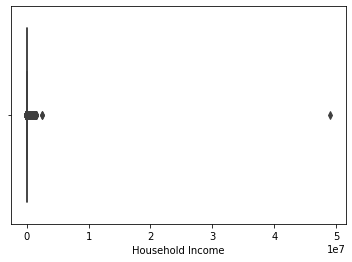

In [81]:
sns.boxplot(x=df["Household Income"])

In [82]:
# Removing Household Incomes of over $500,000 (outlier is at $50,000,000)

df = df[df['Household Income'] <= 500000]

<AxesSubplot:xlabel='Household Income'>

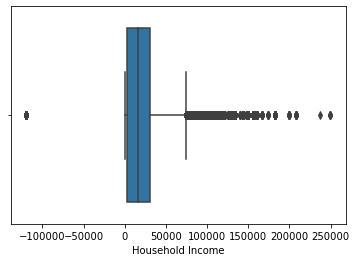

In [83]:
sns.boxplot(x=df["Household Income"])

This shows a clearer graph. We can see there is a negative value, so this should be removed.

In [84]:
df = df[df['Household Income'] >= 0]

<AxesSubplot:xlabel='Household Size'>

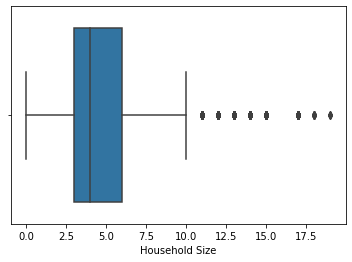

In [85]:
sns.boxplot(x=df["Household Size"])

In [86]:
df = df[df['Household Size'] <= 10]

<AxesSubplot:xlabel='Poverty Level'>

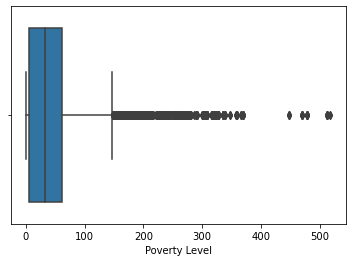

In [87]:
sns.boxplot(x=df["Poverty Level"])

In [88]:
df = df[df['Poverty Level'] <= 150]

#### Correlation Matrix

<AxesSubplot:>

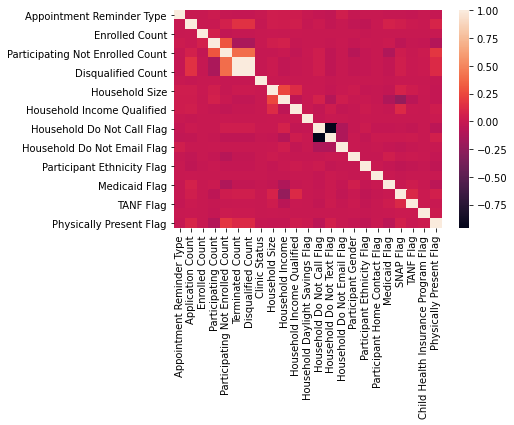

In [89]:
sns.heatmap(df.iloc[:,1:24].corr())

From this map, we can see that we should remove 'Household Do Not Call Flag' as it correlates highly with 'Household Do Not Text Flag'.

<AxesSubplot:>

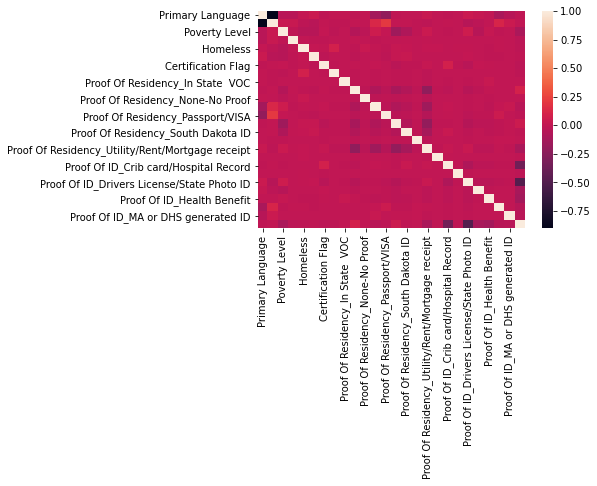

In [90]:
sns.heatmap(df.iloc[:,24:50].corr())

From this map, we can see that we should remove 'Intrepreter Needed' as it correlates highly with 'Primary Language'.

<AxesSubplot:>

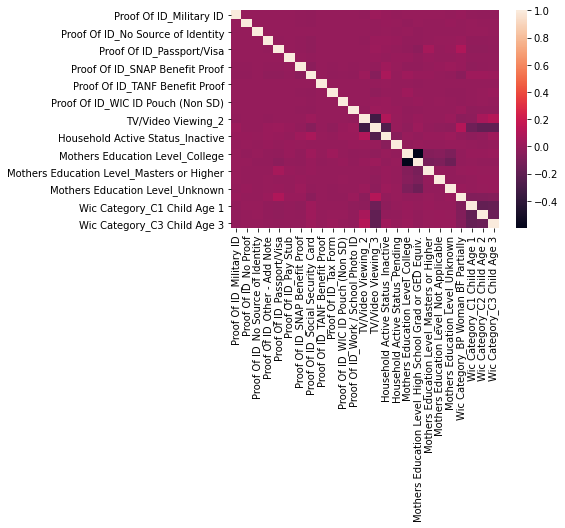

In [91]:
sns.heatmap(df.iloc[:,50:75].corr())

No columns need to be removed due to the highest correlation only being about 0.5-0.6.

<AxesSubplot:>

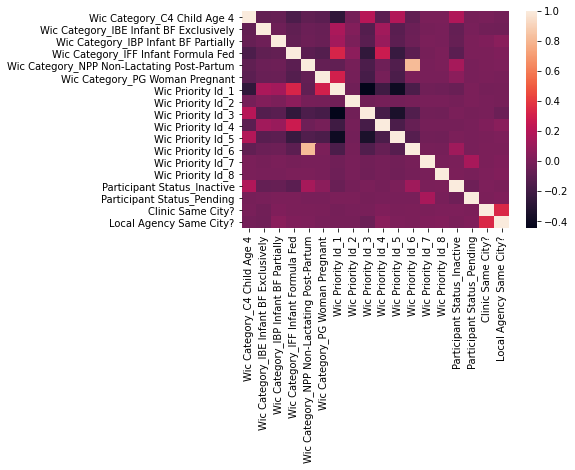

In [92]:
sns.heatmap(df.iloc[:,75:].corr())

No columns need to be removed due to the highest correlation only being about 0.4.

In [93]:
# Seeing which features correlate the most to our target feature

df[df.columns[1:]].corr()['Certification Flag'][:]

Appointment Reminder Type           0.008103
Application Count                  -0.106680
Enrolled Count                     -0.002060
Participating Count                 0.077758
Participating Not Enrolled Count   -0.248456
                                      ...   
Wic Priority Id_8                  -0.003008
Participant Status_Inactive        -0.304587
Participant Status_Pending          0.009407
Clinic Same City?                   0.001292
Local Agency Same City?             0.017772
Name: Certification Flag, Length: 92, dtype: float64

From this list, we see we that we have no variables correlated highly with our target variable.

In [94]:
# Removing highly correlated features

df.drop(['Household Do Not Call Flag','Intrepreter Needed', 'Participating Not Enrolled Count'], axis = 1, inplace = True)

#### Normalizing non-categorial numeric data

In [95]:
normalize_cols = ['Household Income', 'Household Size', 'Poverty Level']
for i in normalize_cols:
    df[i] = (df[i] - min(df[i])) / (max(df[i]) - min(df[i]))

### EDA

In [96]:
pd.set_option('display.max_columns', None)
df.head()

,Participant Key,Appointment Reminder Type,Application Count,Enrolled Count,Participating Count,Terminated Count,Disqualified Count,Clinic Status,Household Size,Household Income,Household Income Qualified,Household Daylight Savings Flag,Household Do Not Text Flag,Household Do Not Email Flag,Participant Gender,Participant Ethnicity Flag,Participant Home Contact Flag,Medicaid Flag,SNAP Flag,TANF Flag,Child Health Insurance Program Flag,Physically Present Flag,Primary Language,Poverty Level,Migrant Flag,Homeless,Smoking In The Household,Certification Flag,Proof Of Residency_Homeless Shelter Address,Proof Of Residency_In State VOC,Proof Of Residency_Medicaid Benefit Proof-Letter,Proof Of Residency_None-No Proof,Proof Of Residency_Other (system note required),Proof Of Residency_Passport/VISA,Proof Of Residency_SNAP Benefit Proof-Verified Card,Proof Of Residency_South Dakota ID,Proof Of Residency_TANF Benefit Proof-Letter,Proof Of Residency_Utility/Rent/Mortgage receipt,Proof Of Residency_Voter Registration,Proof Of ID_Crib card/Hospital Record,Proof Of ID_DO NOT USE!!!Immunization Record,Proof Of ID_Drivers License/State Photo ID,Proof Of ID_Foster Child Record,Proof Of ID_Health Benefit,Proof Of ID_Immigration Papers,Proof Of ID_MA or DHS generated ID,Proof Of ID_Medicaid Card,Proof Of ID_Military ID,Proof Of ID_No Proof,Proof Of ID_No Source of Identity,Proof Of ID_Other - Add Note,Proof Of ID_Passport/Visa,Proof Of ID_Pay Stub,Proof Of ID_SNAP Benefit Proof,Proof Of ID_Social Security Card,Proof Of ID_TANF Benefit Proof,Proof Of ID_Tax Form,Proof Of ID_WIC ID Pouch (Non SD),Proof Of ID_Work / School Photo ID,TV/Video Viewing_2,TV/Video Viewing_3,Household Active Status_Inactive,Household Active Status_Pending,Mothers Education Level_College,Mothers Education Level_High School Grad or GED Equiv.,Mothers Education Level_Masters or Higher,Mothers Education Level_Not Applicable,Mothers Education Level_Unknown,Wic Category_BP Woman BF Partially,Wic Category_C1 Child Age 1,Wic Category_C2 Child Age 2,Wic Category_C3 Child Age 3,Wic Category_C4 Child Age 4,Wic Category_IBE Infant BF Exclusively,Wic Category_IBP Infant BF Partially,Wic Category_IFF Infant Formula Fed,Wic Category_NPP Non-Lactating Post-Partum,Wic Category_PG Woman Pregnant,Wic Priority Id_1,Wic Priority Id_2,Wic Priority Id_3,Wic Priority Id_4,Wic Priority Id_5,Wic Priority Id_6,Wic Priority Id_7,Wic Priority Id_8,Participant Status_Inactive,Participant Status_Pending,Clinic Same City?,Local Agency Same City?
0,2360045,1,1,1,1,1,1,1,0.4,0.282828,1,1,0,1,1,0,0,0,0,0,0,1,1,0.520000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
1,2360045,1,1,1,1,1,1,1,0.4,0.282828,1,1,0,1,1,0,0,0,0,0,0,1,1,0.520000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
2,2362160,1,1,1,0,1,1,1,0.5,0.032634,1,1,1,1,0,0,0,1,1,0,0,1,1,0.053333,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,2362160,1,1,1,0,1,1,1,0.5,0.032634,1,1,1,1,0,0,0,1,1,0,0,1,1,0.053333,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,2362160,1,1,1,1,1,1,1,0.5,0.032634,1,1,1,1,0,0,0,1,1,0,0,1,1,0.053333,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


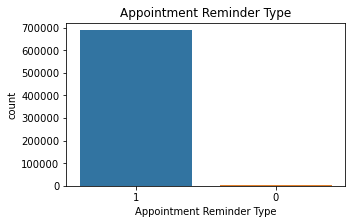

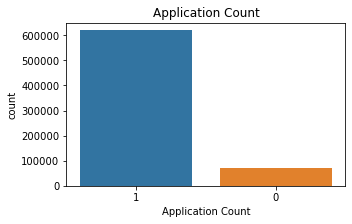

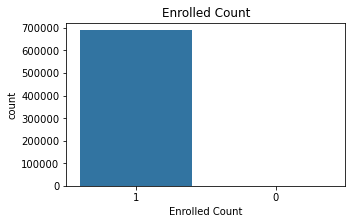

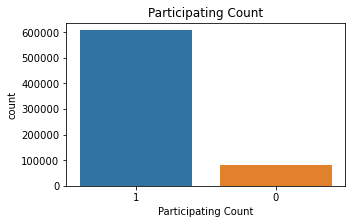

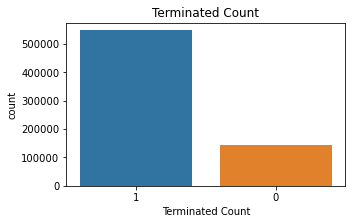

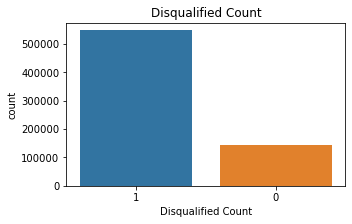

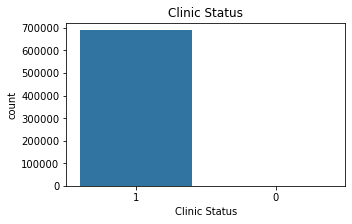

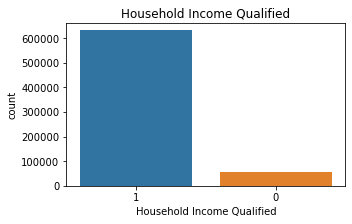

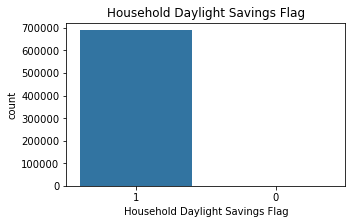

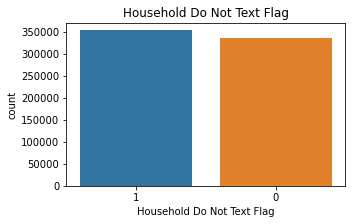

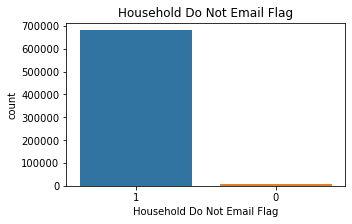

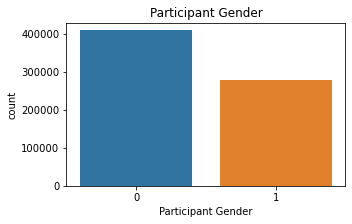

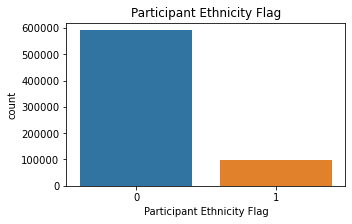

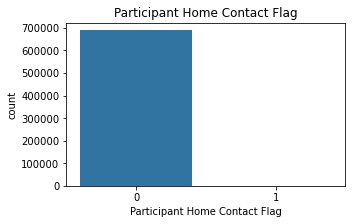

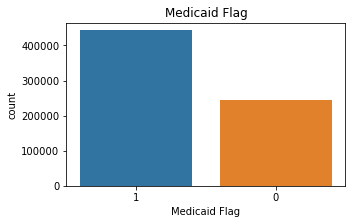

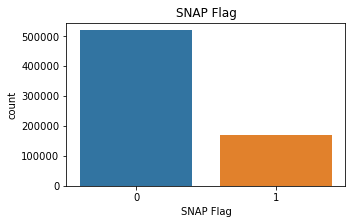

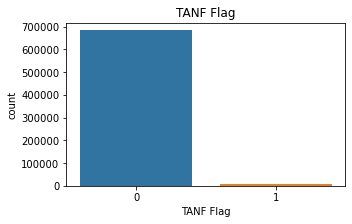

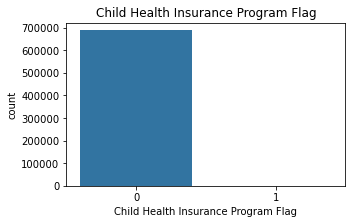

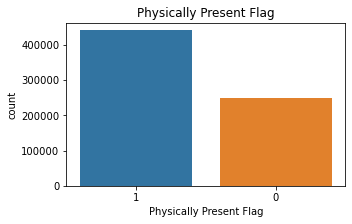

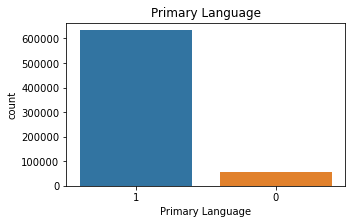

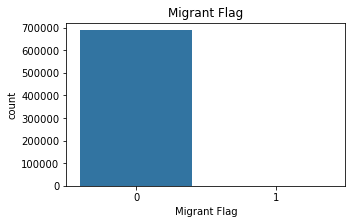

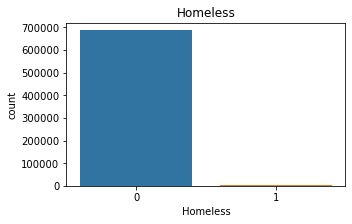

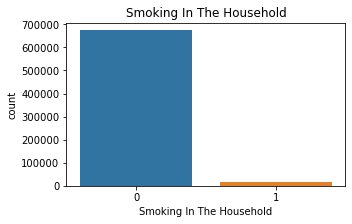

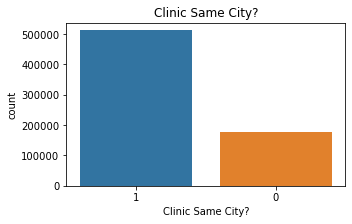

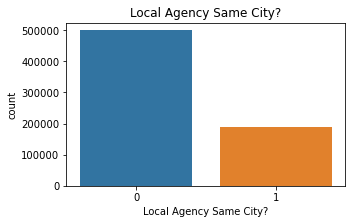

In [107]:
# Seeing predictor binary columns spread
predictor_binary = ['Appointment Reminder Type', 'Application Count',
       'Enrolled Count', 'Participating Count', 'Terminated Count',
       'Disqualified Count', 'Clinic Status',
       'Household Income Qualified',
       'Household Daylight Savings Flag', 'Household Do Not Text Flag',
       'Household Do Not Email Flag', 'Participant Gender',
       'Participant Ethnicity Flag', 'Participant Home Contact Flag',
       'Medicaid Flag', 'SNAP Flag', 'TANF Flag',
       'Child Health Insurance Program Flag', 'Physically Present Flag',
       'Primary Language', 'Migrant Flag', 'Homeless',
       'Smoking In The Household', 'Clinic Same City?', 'Local Agency Same City?']

for i in predictor_binary:
    plt.figure(figsize=(5, 3))
    plt.title(i)
    sns.countplot(data=df, x=i, order = df[i].value_counts().index)
    plt.show()

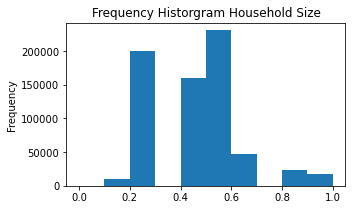

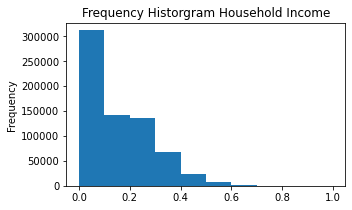

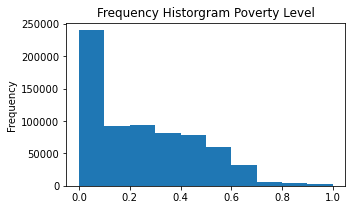

In [110]:
# Seeing predictor non-binary column spread
predictor_nonbinary = ['Household Size', 'Household Income', 'Poverty Level']

for i in predictor_nonbinary:
    plt.figure(figsize=(5, 3))
    plt.hist(df[i], bins=10)
    plt.gca().set(title='Frequency Historgram ' + i, ylabel='Frequency')

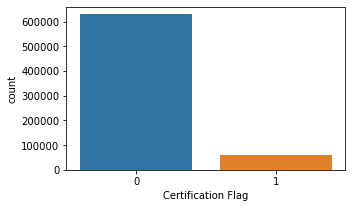

In [59]:
# Seeing target column spread
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Certification Flag', order = df['Certification Flag'].value_counts().index)
plt.show()

Our data is imbalanced, which means resampling will have to be done.

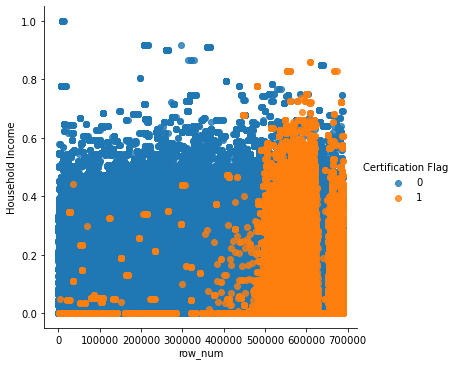

In [60]:
df_plot = df
df_plot['row_num'] = np.arange(len(df))
sns.lmplot(y='Household Income', x = 'row_num', data = df_plot, hue = 'Certification Flag', fit_reg=False)

It is difficult to see from the chart, but there appears to be a higher concentration of high incomes with a certification flag of 0. This makes sense as WIC aims to aid lower income families.

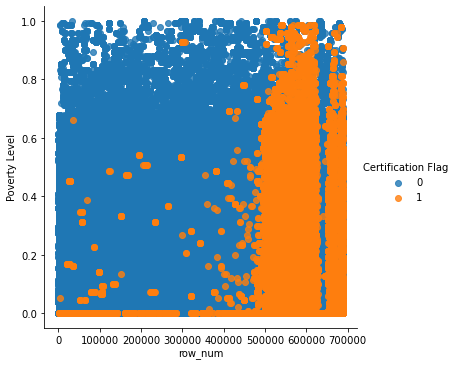

In [61]:
sns.lmplot(y='Poverty Level', x = 'row_num', data = df_plot, hue = 'Certification Flag', fit_reg=False)

It also appears that higher poverty levels could indicate a certification flag of 0. This could mean that being on the ends of the wealth spectrum have an influence if you remain in the WIC program.

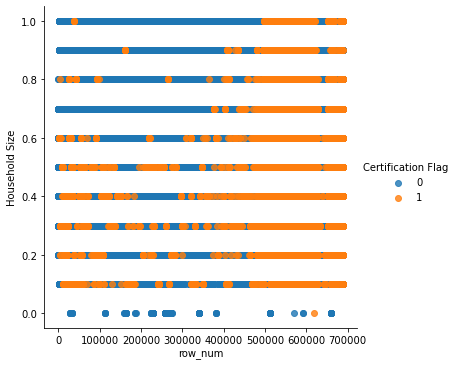

In [62]:
sns.lmplot(y='Household Size', x = 'row_num', data = df_plot, hue = 'Certification Flag', fit_reg=False)

Those with a low household size tend to not use the WIC program, which is logical as the program aims to aids families.

#### Saving data to CSV

In [63]:
# saving df to csv

df.to_csv("df_cleaned.csv")